In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
!mkdir speech_data
%cd speech_data
!mkdir model_weights 

/content/speech_data


In [0]:
labels = ['up', 'three', 'four', 'stop', 'left', 'on', 'six', 'right', 'go', 'seven', 'no', 'one', 'off', 'yes', 'nine', 'zero', 'two', 'down', 'five', 'eight']


In [13]:

from shutil import copyfile

for label in labels:
  copyfile('/content/drive/My Drive/cs419_data/'+label+'.mat','/content/speech_data/'+label+'.mat')

!ls

down.mat   four.mat  model_weights  off.mat  right.mat	stop.mat   up.mat
eight.mat  go.mat    nine.mat	    one.mat  seven.mat	three.mat  yes.mat
five.mat   left.mat  no.mat	    on.mat   six.mat	two.mat    zero.mat


In [14]:
import scipy.io as sio
import numpy as np

x = np.arange(8000)
y = []
for label in labels:
  print(label)
  m = sio.loadmat(label+'.mat')
  m = m['samples']
  x = np.vstack((x,m))
  y = y + [label]*m.shape[0]
  #print(m.shape[0])
  #print("----")

#Delete the initial row
x = np.delete(x,0,axis = 0)

up
three
four
stop
left
on
six
right
go
seven
no
one
off
yes
nine
zero
two
down
five
eight


In [20]:
from sklearn.preprocessing import OneHotEncoder

y_array = np.array(y).reshape(-1,1)

ohe = OneHotEncoder()
ohe.fit(y_array)
y_enc = ohe.transform(y_array).toarray()
print(y_enc)

#To get inverse mapping, use
#z = np.zeros((1,20))
#[0,-3] =1 
#print(ohe.inverse_transform(z)[0,0])

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


In [21]:
from sklearn.model_selection import train_test_split

x1,x_test,y1,y_test = train_test_split(x,y_enc,test_size=0.2,random_state=12,shuffle = True)
x_train,x_val,y_train,y_val = train_test_split(x1,y1,test_size=0.25,random_state=12,shuffle = True)

print(x_test.shape)
print(y_test.shape)

print(x_val.shape)
print(y_val.shape)

print(x_train.shape)
print(y_train.shape)

#8575 Test
#8575 Val
#25724 Train

(8575, 8000)
(8575, 20)
(8575, 8000)
(8575, 20)
(25724, 8000)
(25724, 20)


In [23]:
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense

from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

NUM_EPOCHS = 10
BATCH_SIZE = 32
EARLY_STOP_PATIENCE = 3

model = Sequential()
model.add(Dense(20, input_dim=8000, activation='softmax'))

adm = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)

model.compile(loss='categorical_crossentropy', optimizer= adm , metrics=['accuracy'])
model.summary()

name = "model_weights/weights.{epoch:02d}-{val_loss:.3f}.hdf5"
early_stopper = EarlyStopping(monitor = 'val_acc', patience = EARLY_STOP_PATIENCE)
checkpointer = ModelCheckpoint(filepath = name, monitor = 'val_acc', save_best_only = True, mode = 'auto')

fit_hist = model.fit(x = x_train, 
          y = y_train,
          batch_size = BATCH_SIZE,
          epochs = NUM_EPOCHS,
          verbose = 1,
          validation_data=(x_val,y_val),
          callbacks=[checkpointer, early_stopper])

score = model.evaluate(x_test, y_test,batch_size=BATCH_SIZE,verbose=1)

print("____TEST SET SCORES_____")
print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))
print("%s: %.2f%%" % (model.metrics_names[0], score[0]))


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                160020    
Total params: 160,020
Trainable params: 160,020
Non-trainable params: 0
_________________________________________________________________
Train on 25724 samples, validate on 8575 samples
Epoch 1/10
25724/25724 [==============================] - 5s 187us/step - loss: 3.0292 - acc: 0.0663 - val_loss: 3.0380 - val_acc: 0.0743
Epoch 2/10
25724/25724 [==============================] - 5s 181us/step - loss: 2.7775 - acc: 0.1923 - val_loss: 3.1064 - val_acc: 0.0759
Epoch 3/10
25724/25724 [==============================] - 5s 180us/step - loss: 2.6375 - acc: 0.2408 - val_loss: 3.1818 - val_acc: 0.0786
Epoch 4/10
25724/25724 [==============================] - 5s 182us/step - loss: 2.5400 - acc: 0.2743 - val_loss: 3.2535 - val_acc: 0.0790
Epoch 5/10
25724/25724 [=================

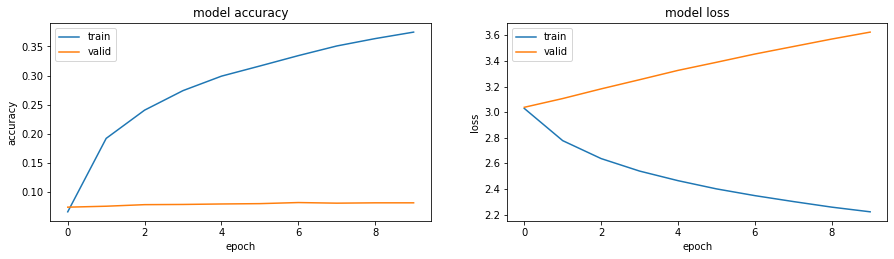

In [24]:
import matplotlib.pyplot as plt
#print(fit_hist.history.keys())

plt.figure(1, figsize = (15,8)) 
    
plt.subplot(221)  
plt.plot(fit_hist.history['acc'])  
plt.plot(fit_hist.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 
    
plt.subplot(222)  
plt.plot(fit_hist.history['loss'])  
plt.plot(fit_hist.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'valid']) 

plt.show()

8575/8575 [==============================] - 1s 102us/step


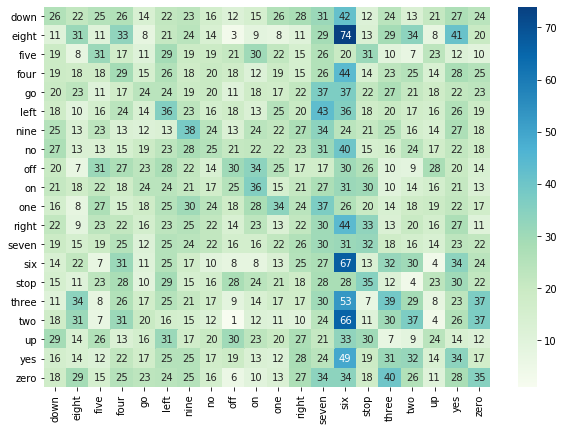

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

from keras.utils.np_utils import to_categorical   

y_pred = model.predict(x_test,batch_size=BATCH_SIZE,verbose=1)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))

df_cm = pd.DataFrame(matrix, index = [ohe.inverse_transform(to_categorical(i, num_classes=20).reshape(1,-1))[0,0] for i in range(len(labels))],
                  columns = [ohe.inverse_transform(to_categorical(i, num_classes=20).reshape(1,-1))[0,0] for i in range(len(labels))])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True,cmap='GnBu')
